# Pneumonia Chest X-ray Pipeline From Scratch
  
- This notebook covers: data loading, fast full-path resolution, EDA, a **from-scratch CNN**, class imbalance handling, training & evaluation (Accuracy/Precision/Recall/F1, ROC/PR curves, confusion matrix).

## 1. Paths & Training Hyperparameters

In [13]:
import os, sys, math, time, random, itertools
from typing import Tuple, List, Dict

IMG_ROOT = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images"
TRAIN_CSV = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv"
TEST_CSV  = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv"

OUT_DIR   = "./cnn_from_scratch_output"

EPOCHS    = 30
BATCH     = 32
LR        = 3e-4
SEED      = 42
VAL_RATIO = 0.20       
SAMPLER   = "off"   

print("IMG_ROOT:", IMG_ROOT)
print("TRAIN_CSV:", TRAIN_CSV)
print("TEST_CSV:", TEST_CSV)
print("OUT_DIR:", OUT_DIR)
print("EPOCHS/BATCH/LR:", EPOCHS, BATCH, LR)
print("VAL_RATIO/SAMPLER:", VAL_RATIO, SAMPLER)

IMG_ROOT: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images
TRAIN_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv
TEST_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv
OUT_DIR: ./cnn_from_scratch_output
EPOCHS/BATCH/LR: 30 32 0.0003
VAL_RATIO/SAMPLER: 0.2 off


## 2. Imports & Device
Set seeds and device. Use `matplotlib` only for plots.

In [2]:
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             confusion_matrix, roc_curve, precision_recall_curve)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"figure.dpi": 110})

def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(SEED)
print(f"Using device: {device} | AMP: {'on' if device.type=='cuda' else 'off'}")

Using device: cuda | AMP: on


## 3. Read CSVs & Quick Preview
Load train/test CSVs, print shapes/columns, and check class distribution.

In [3]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

display(train_df.head(8))
display(test_df.head(8))

print("Train shape:", train_df.shape, "Columns:", list(train_df.columns))
print("Test  shape:", test_df.shape, "Columns:", list(test_df.columns))

print("Train label distribution:", train_df["has_pneumo"].value_counts().to_dict())
print("Test  label distribution:", test_df["has_pneumo"].value_counts().to_dict())

,new_filename,ImageId,has_pneumo
0,0_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,0
1,1_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,0
2,2_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,1
3,3_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,1
4,4_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.1314.151787516...,1
5,5_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.11364.15178752...,0
6,6_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.4541.151787518...,0
7,7_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4440.151787518...,1


,new_filename,ImageId,has_pneumo
0,0_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5797.151787519...,1
1,1_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5798.151787519...,0
2,2_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5799.151787519...,0
3,3_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.580.1517875163...,0
4,4_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5800.151787519...,0
5,5_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5801.151787519...,0
6,6_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5802.151787519...,1
7,7_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5803.151787519...,1


Train shape: (10675, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Test  shape: (1372, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Train label distribution: {0: 8296, 1: 2379}
Test  label distribution: {0: 1082, 1: 290}


## 4. Full-path Resolution & Dataset 
Pre-compute `full_path` in the DataFrame to speed up IO; the Dataset only opens `full_path`.

In [4]:
def resolve_full_paths(df: pd.DataFrame, img_root: str) -> pd.DataFrame:
    df = df.copy()
    def _resolve(row):
        name = str(row["new_filename"])
        name_png = name if name.lower().endswith(".png") else f"{name}.png"
        p1 = os.path.join(img_root, name_png)
        if os.path.exists(p1):
            return p1
        # fallback: ImageId.png
        alt = os.path.join(img_root, f"{row['ImageId']}.png")
        return alt if os.path.exists(alt) else p1
    df["full_path"] = df.apply(_resolve, axis=1)
    return df

train_df = resolve_full_paths(train_df, IMG_ROOT)
test_df  = resolve_full_paths(test_df,  IMG_ROOT)

missing_train = (~train_df["full_path"].apply(os.path.exists)).sum()
missing_test  = (~test_df["full_path"].apply(os.path.exists)).sum()
print(f"Missing files — Train: {missing_train} | Test: {missing_test}")

class PandasImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["full_path"]).convert("L")
        if self.transform: img = self.transform(img)
        y = int(row["has_pneumo"])
        return img, y

Missing files — Train: 0 | Test: 0


## 5. EDA Utility Functions
Class distribution bar chart, missing files report, and sample grid visualization.

In [5]:
os.makedirs(OUT_DIR, exist_ok=True)
EDA_DIR = os.path.join(OUT_DIR, "eda"); os.makedirs(EDA_DIR, exist_ok=True)

def eda_class_distribution(df: pd.DataFrame, label_col: str, out_path: str, title: str):
    counts = df[label_col].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    xs = [str(int(x)) for x in counts.index.tolist()]
    ys = counts.values.astype(int)
    plt.bar(xs, ys)
    for i, y in enumerate(ys):
        plt.text(i, y, str(y), ha="center", va="bottom", fontsize=9)
    plt.title(f"Class Distribution — {title}")
    plt.xlabel("Label"); plt.ylabel("Count")
    plt.tight_layout(); plt.savefig(out_path); plt.show()

def eda_missing_files(df: pd.DataFrame, out_txt: str, title: str):
    missing_mask = ~df["full_path"].apply(os.path.exists)
    total = len(df); missing = missing_mask.sum()
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write(f"Total rows: {total}\nMissing files: {missing}\n")
        if missing:
            f.write("First 50 missing examples:\n")
            f.write("\n".join(df.loc[missing_mask, "full_path"].head(50).tolist()))
    print(f"[{title}] Missing: {missing}/{total} — saved to {out_txt}")

def eda_sample_grid(df: pd.DataFrame, out_path: str, title: str, n_per_class: int = 8, size: int = 128):
    labels = sorted(df["has_pneumo"].unique().tolist())
    panels = []
    for lab in labels:
        subset = df[df["has_pneumo"] == lab]
        sample = subset.sample(min(n_per_class, len(subset)), random_state=0)
        panels.append(sample)

    cols = n_per_class; rows = len(labels)
    plt.figure(figsize=(cols*2, rows*2))
    idx = 1
    for r, panel in enumerate(panels):
        for _, row in panel.iterrows():
            fp = row["full_path"]
            plt.subplot(rows, cols, idx)
            try:
                img = Image.open(fp).convert("L").resize((size,size))
                plt.imshow(img, cmap="gray"); plt.axis("off")
            except Exception:
                plt.text(0.5,0.5,"missing",ha="center",va="center"); plt.axis("off")
            idx += 1
    plt.suptitle(f"Sample Grid — {title}", y=0.98)
    plt.tight_layout(); plt.savefig(out_path); plt.show()

## 6. Run EDA
Produce distribution plots, missing-file report, and sample grid.

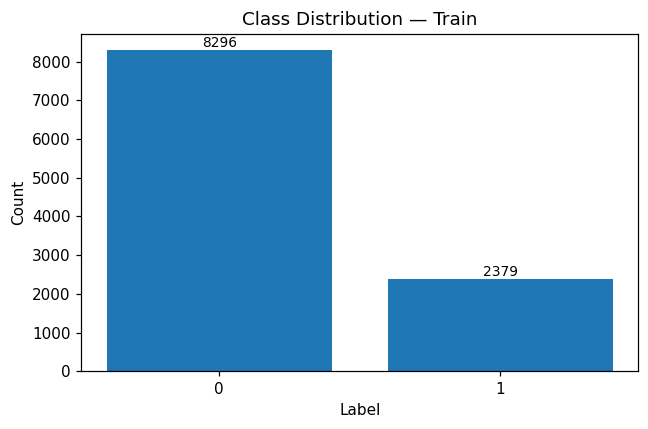

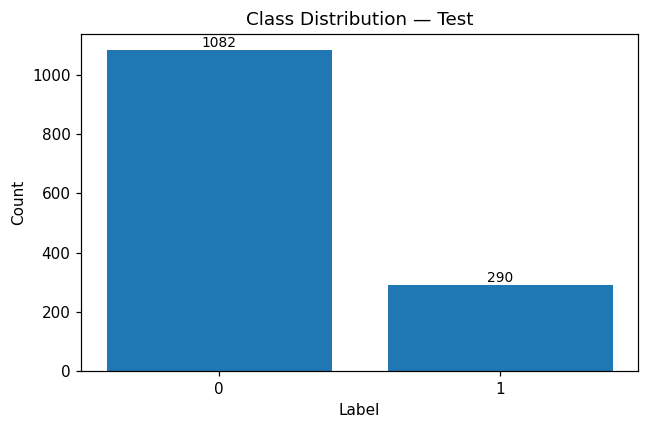

[Train] Missing: 0/10675 — saved to ./cnn_from_scratch_output\eda\missing_train.txt
[Test] Missing: 0/1372 — saved to ./cnn_from_scratch_output\eda\missing_test.txt


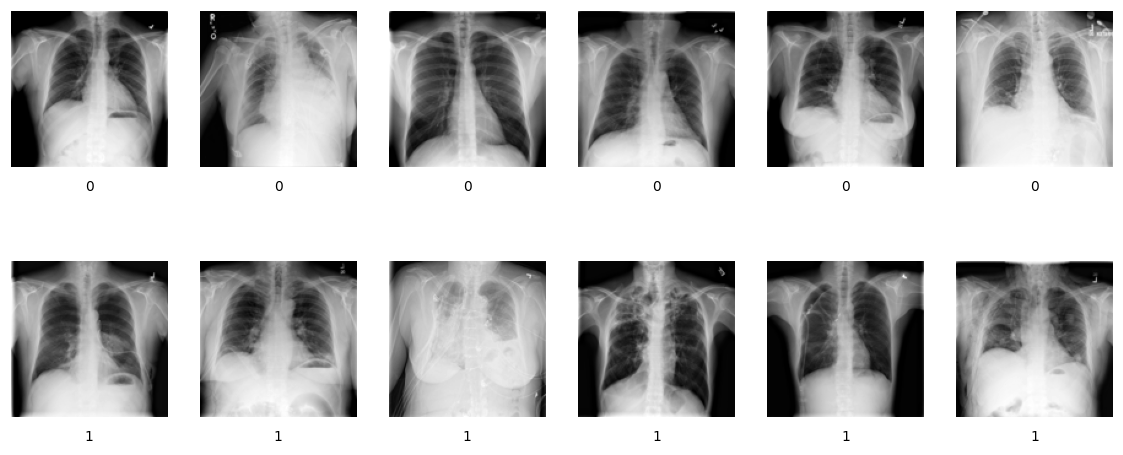

In [7]:
from pathlib import Path

eda_class_distribution(train_df, "has_pneumo", os.path.join(EDA_DIR, "class_dist_train.png"), "Train")
eda_class_distribution(test_df,  "has_pneumo", os.path.join(EDA_DIR, "class_dist_test.png"),  "Test")

eda_missing_files(train_df, os.path.join(EDA_DIR, "missing_train.txt"), "Train")
eda_missing_files(test_df,  os.path.join(EDA_DIR, "missing_test.txt"),  "Test")

def eda_sample_grid(df, out_path, split_name, n_per_class=6, size=128):
    label_col = "has_pneumo"
    path_col = "full_path" if "full_path" in df.columns else "filepath"

    classes = sorted(df[label_col].dropna().unique().tolist())
    nrows, ncols = len(classes), n_per_class
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.2, nrows*2.4))
    if nrows == 1:
        axes = np.array([axes])

    for r, c in enumerate(classes):
        sub = df[df[label_col] == c]
        sampled = sub.sample(n=min(n_per_class, len(sub)), random_state=42) if len(sub) > 0 else sub
        sampled = sampled.reset_index(drop=True)

        for i in range(ncols):
            ax = axes[r, i]
            ax.set_axis_off()

            if i < len(sampled):
                row = sampled.iloc[i]
                img_path = str(Path(row[path_col]))
                try:
                    im = Image.open(img_path).convert("L")
                    if size:
                        im = im.resize((size, size))
                    ax.imshow(im, cmap="gray")
                except Exception:
                    ax.imshow(np.zeros((size, size)), cmap="gray")

                ax.text(0.5, -0.08, str(row[label_col]),
                        transform=ax.transAxes, ha="center", va="top", fontsize=9)
            else:
                ax.imshow(np.zeros((size, size)), cmap="gray")

    plt.subplots_adjust(hspace=0.6, wspace=0.05)
    plt.show()
    Path(os.path.dirname(out_path)).mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

eda_sample_grid(train_df, os.path.join(EDA_DIR, "sample_grid_train.png"), "Train", n_per_class=6, size=128)

## 7. Split, Transforms & DataLoaders  
Stratified split; light augmentation and normalization; optional weighted sampler.

In [8]:
# Stratified split
tr_df, val_df = train_test_split(train_df, test_size=VAL_RATIO,
                                 stratify=train_df["has_pneumo"], random_state=SEED)

# Transforms
train_tfms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25]),
])
eval_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25]),
])

# Datasets
ds_train = PandasImageDataset(tr_df, transform=train_tfms)
ds_val   = PandasImageDataset(val_df, transform=eval_tfms)
ds_test  = PandasImageDataset(test_df, transform=eval_tfms)

def make_weights_for_balancing(df: pd.DataFrame) -> np.ndarray:
    counts = df["has_pneumo"].value_counts().to_dict()
    return df["has_pneumo"].map(lambda y: 1.0 / counts[int(y)]).values.astype(np.float32)

if SAMPLER == "on":
    weights = make_weights_for_balancing(tr_df)
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    shuffle = False
else:
    sampler = None; shuffle = True

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=BATCH, sampler=sampler, shuffle=shuffle,
                      num_workers=0, pin_memory=True)
dl_val   = DataLoader(ds_val, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
dl_test  = DataLoader(ds_test, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

len(ds_train), len(ds_val), len(ds_test)

(8540, 2135, 1372)

## 8. CNN From Scratch  
Lightweight CNN (1×224×224) with conv blocks + GAP + FC.

In [9]:
class SmallCNN(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28x28

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 64), nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(64, n_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.squeeze(1)  # [B]

model = SmallCNN(n_classes=1).to(device)

## 9. Imbalance-Aware Loss & Optimizer  
`BCEWithLogitsLoss` with `pos_weight`, Adam optimizer, cosine LR schedule; AMP for speed.

In [10]:
pos = (np.array(tr_df["has_pneumo"])==1).sum()
neg = (np.array(tr_df["has_pneumo"])==0).sum()
pos_weight = torch.tensor([neg / max(pos,1)], device=device, dtype=torch.float32)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

print("pos/neg:", pos, neg, "| pos_weight:", pos_weight.item())

pos/neg: 1903 6637 | pos_weight: 3.4876511096954346


C:\Users\Steven\AppData\Local\Temp\ipykernel_82092\2815105705.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


## 10. Evaluation Utilities
Compute metrics; plot ROC/PR curves and confusion matrix.

In [11]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    ys, preds, scores = [], [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        probs = torch.sigmoid(logits)
        pred = (probs >= 0.5).long()
        ys.extend(yb.cpu().numpy().tolist())
        preds.extend(pred.cpu().numpy().tolist())
        scores.extend(probs.cpu().numpy().tolist())
    y_true = np.array(ys); y_pred = np.array(preds); y_score = np.array(scores)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    try:    roc = roc_auc_score(y_true, y_score)
    except: roc = float("nan")
    try:    pr  = average_precision_score(y_true, y_score)
    except: pr  = float("nan")
    return {"acc":acc,"prec":prec,"rec":rec,"f1":f1,"roc_auc":roc,"pr_auc":pr}, y_true, y_pred, y_score

def plot_confusion_matrix(y_true, y_pred, out_path, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title); plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ['0','1']); plt.yticks(ticks, ['0','1'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
    plt.ylabel("Actual"); plt.xlabel("Predicted")
    plt.tight_layout(); plt.savefig(out_path); plt.show()

def plot_roc_pr(y_true, y_score, out_dir, prefix="eval"):
    os.makedirs(out_dir, exist_ok=True)
    # ROC
    try:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label="ROC")
        plt.plot([0,1],[0,1], linestyle="--")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")
        plt.tight_layout(); plt.savefig(os.path.join(out_dir, f"{prefix}_roc.png")); plt.show()
    except Exception as e:
        print("ROC failed:", e)
    # PR
    try:
        prec, rec, _ = precision_recall_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(rec, prec, label="PR")
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curve")
        plt.tight_layout(); plt.savefig(os.path.join(out_dir, f"{prefix}_pr.png")); plt.show()
    except Exception as e:
        print("PR failed:", e)

## 11. Training Loop (AMP + Correct Scheduler Order) with early stop 
For each epoch, call `optimizer.step()` before `scheduler.step()`; track best F1 on val.

In [14]:
from tqdm.auto import tqdm

MONITOR    = "pr_auc"
MODE       = "max"
PATIENCE   = 4
MIN_EPOCHS = 5
DELTA      = 1e-4

best_score   = -float('inf')
best_epoch   = 0
epochs_bad   = 0
BEST_STATE   = None

print("[Info] Start training...")
for epoch in range(1, EPOCHS+1):
    model.train()
    running, nb = 0.0, 0
    bar = tqdm(total=len(dl_train), leave=True, desc=f"Epoch {epoch}/{EPOCHS}")

    for xb, yb in dl_train:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True).float()

        optimizer.zero_grad(set_to_none=True)
        
        with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
            logits = model(xb)
            loss = criterion(logits, yb)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step() 

        running += loss.item(); nb += 1
      
        try: curr_lr = scheduler.get_last_lr()[0]
        except: curr_lr = optimizer.param_groups[0]["lr"]
        bar.set_postfix(loss=f"{running/max(nb,1):.4f}", lr=f"{curr_lr:.2e}")
        bar.update(1)
    bar.close()

    metrics, yv, pv, sv = evaluate(model, dl_val, device)
    score = float(metrics.get(MONITOR, float('nan')))
    improved = score > (best_score + DELTA)

    if improved:
        best_score = score
        best_epoch = epoch
        BEST_STATE = {k: v.cpu() for k, v in model.state_dict().items()}
        epochs_bad = 0
    else:
        epochs_bad += 1

    tqdm.write(
        f"Epoch {epoch:02d}/{EPOCHS} loss={running/max(nb,1):.4f} "
        f"val_acc={metrics['acc']:.4f} val_prec={metrics['prec']:.4f} "
        f"val_rec={metrics['rec']:.4f} val_f1={metrics['f1']:.4f} "
        f"val_{MONITOR}={score:.4f} | best_{MONITOR}={best_score:.4f} (epoch {best_epoch})"
    )

    if epoch >= MIN_EPOCHS and epochs_bad >= PATIENCE:
        tqdm.write(f"[EarlyStop] Stop at epoch {epoch}. Best {MONITOR}={best_score:.4f} @ epoch {best_epoch}.")
        break

if BEST_STATE is not None:
    torch.save(BEST_STATE, os.path.join(OUT_DIR, "best_cnn.pt"))
    model.load_state_dict(BEST_STATE)


[Info] Start training...


Epoch 1/30:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 01/30 loss=0.8819 val_acc=0.3016 val_prec=0.2396 val_rec=0.9811 val_f1=0.3852 val_pr_auc=0.5515 | best_pr_auc=0.5515 (epoch 1)


Epoch 2/30:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 02/30 loss=0.8695 val_acc=0.4773 val_prec=0.2917 val_rec=0.9412 val_f1=0.4453 val_pr_auc=0.5371 | best_pr_auc=0.5515 (epoch 1)


Epoch 3/30:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 03/30 loss=0.8586 val_acc=0.5475 val_prec=0.3169 val_rec=0.8908 val_f1=0.4675 val_pr_auc=0.5784 | best_pr_auc=0.5784 (epoch 3)


Epoch 4/30:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 04/30 loss=0.8392 val_acc=0.3110 val_prec=0.2410 val_rec=0.9727 val_f1=0.3863 val_pr_auc=0.5074 | best_pr_auc=0.5784 (epoch 3)


Epoch 5/30:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 05/30 loss=0.8377 val_acc=0.7326 val_prec=0.4395 val_rec=0.7248 val_f1=0.5472 val_pr_auc=0.6124 | best_pr_auc=0.6124 (epoch 5)


Epoch 6/30:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 06/30 loss=0.8238 val_acc=0.6005 val_prec=0.3474 val_rec=0.9013 val_f1=0.5015 val_pr_auc=0.6190 | best_pr_auc=0.6190 (epoch 6)


Epoch 7/30:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 07/30 loss=0.8232 val_acc=0.7733 val_prec=0.4940 val_rec=0.6912 val_f1=0.5762 val_pr_auc=0.6266 | best_pr_auc=0.6266 (epoch 7)


Epoch 8/30:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 08/30 loss=0.8002 val_acc=0.8000 val_prec=0.5478 val_rec=0.5903 val_f1=0.5683 val_pr_auc=0.6006 | best_pr_auc=0.6266 (epoch 7)


Epoch 9/30:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 09/30 loss=0.8030 val_acc=0.6290 val_prec=0.3656 val_rec=0.9034 val_f1=0.5206 val_pr_auc=0.6408 | best_pr_auc=0.6408 (epoch 9)


Epoch 10/30:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 10/30 loss=0.7896 val_acc=0.7447 val_prec=0.4590 val_rec=0.8109 val_f1=0.5862 val_pr_auc=0.6216 | best_pr_auc=0.6408 (epoch 9)


Epoch 11/30:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 11/30 loss=0.7926 val_acc=0.7888 val_prec=0.5179 val_rec=0.7584 val_f1=0.6155 val_pr_auc=0.6298 | best_pr_auc=0.6408 (epoch 9)


Epoch 12/30:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 12/30 loss=0.7857 val_acc=0.7457 val_prec=0.4596 val_rec=0.8004 val_f1=0.5839 val_pr_auc=0.6275 | best_pr_auc=0.6408 (epoch 9)


Epoch 13/30:   0%|          | 0/267 [00:00<?, ?it/s]

Epoch 13/30 loss=0.7869 val_acc=0.7485 val_prec=0.4612 val_rec=0.7626 val_f1=0.5748 val_pr_auc=0.6392 | best_pr_auc=0.6408 (epoch 9)
[EarlyStop] Stop at epoch 13. Best pr_auc=0.6408 @ epoch 9.


## 12. Final Evaluation & Plots  
Evaluate on val/test; save confusion matrices and ROC/PR plots.

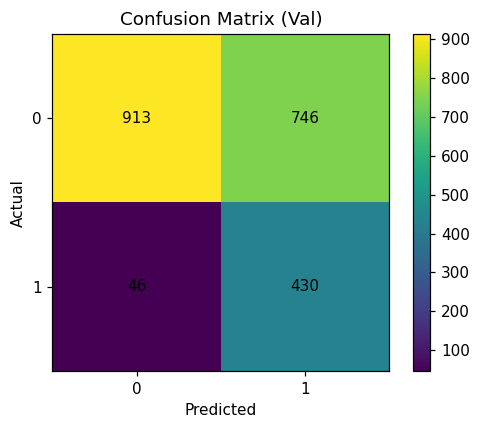

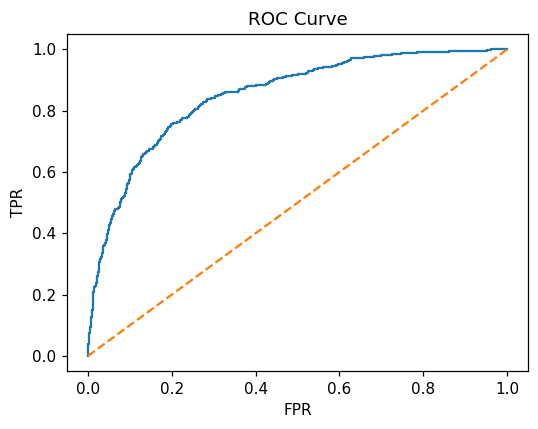

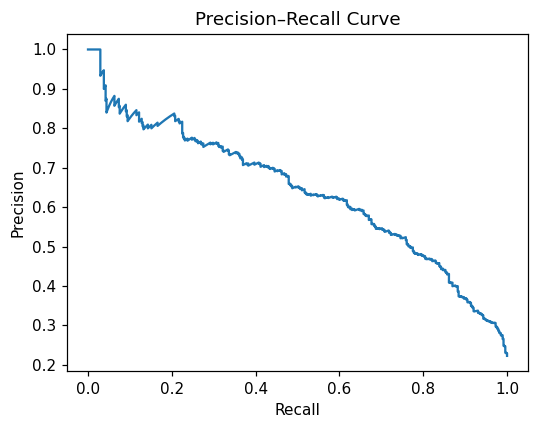

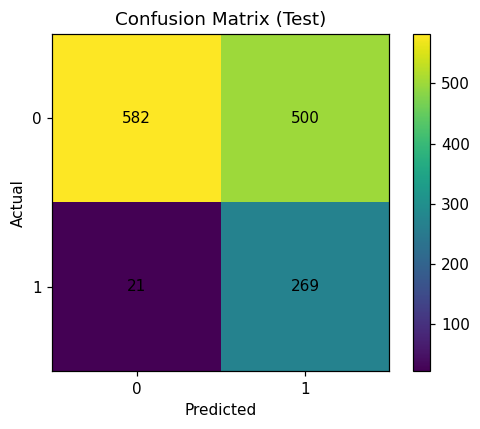

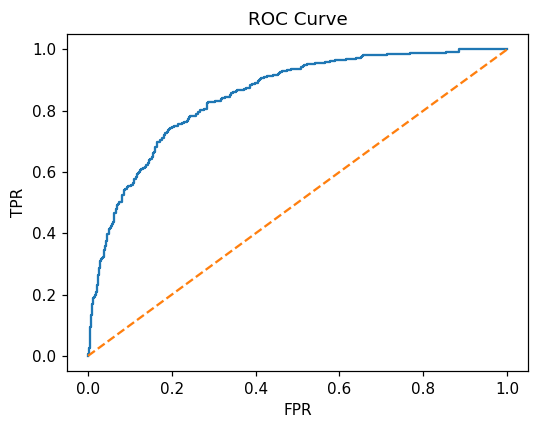

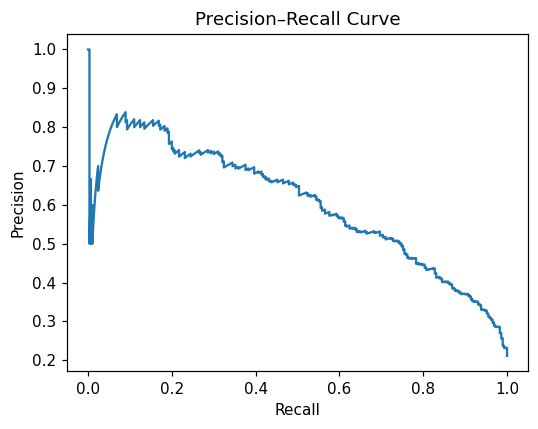

Val: {'acc': 0.62903981264637, 'prec': 0.3656462585034014, 'rec': 0.9033613445378151, 'f1': 0.5205811138014528, 'roc_auc': np.float64(0.8503654626407525), 'pr_auc': np.float64(0.6408387639618809)}
Test: {'acc': 0.6202623906705539, 'prec': 0.34980494148244473, 'rec': 0.9275862068965517, 'f1': 0.5080264400377715, 'roc_auc': np.float64(0.8490152336031614), 'pr_auc': np.float64(0.6025924049564756)}


In [15]:
VAL_METRICS, y_true_v, y_pred_v, y_score_v = evaluate(model, dl_val, device)
TEST_METRICS, y_true_t, y_pred_t, y_score_t = evaluate(model, dl_test, device)

import json
with open(os.path.join(OUT_DIR, "metrics.json"), "w", encoding="utf-8") as f:
    json.dump({"val": VAL_METRICS, "test": TEST_METRICS}, f, indent=2)

plot_confusion_matrix(y_true_v, y_pred_v, os.path.join(OUT_DIR, "cm_val.png"),  "Confusion Matrix (Val)")
plot_roc_pr(y_true_v, y_score_v, OUT_DIR, prefix="val")

plot_confusion_matrix(y_true_t, y_pred_t, os.path.join(OUT_DIR, "cm_test.png"), "Confusion Matrix (Test)")
plot_roc_pr(y_true_t, y_score_t, OUT_DIR, prefix="test")

print("Val:", VAL_METRICS)
print("Test:", TEST_METRICS)